In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from bidding_environment import FirstPriceAuction
from bidding import HedgeAgent, FFMultiplicativePacingAgent
from Competing_bids_generator import generate_bids

In [2]:
import random

def generate_adversarial_bids(N, M):
    bids = []
    for _ in range(N):
        bid = []
        for _ in range(M):
            # Generate a random bid value between 0 and 1
            value = random.uniform(0, 1)
            bid.append(value)
        bids.append(bid)
    
    # Introduce adversarial elements by shuffling bids in non-obvious ways
    random.shuffle(bids)
    for i in range(N):
        random.shuffle(bids[i])
    
    return np.array(bids)


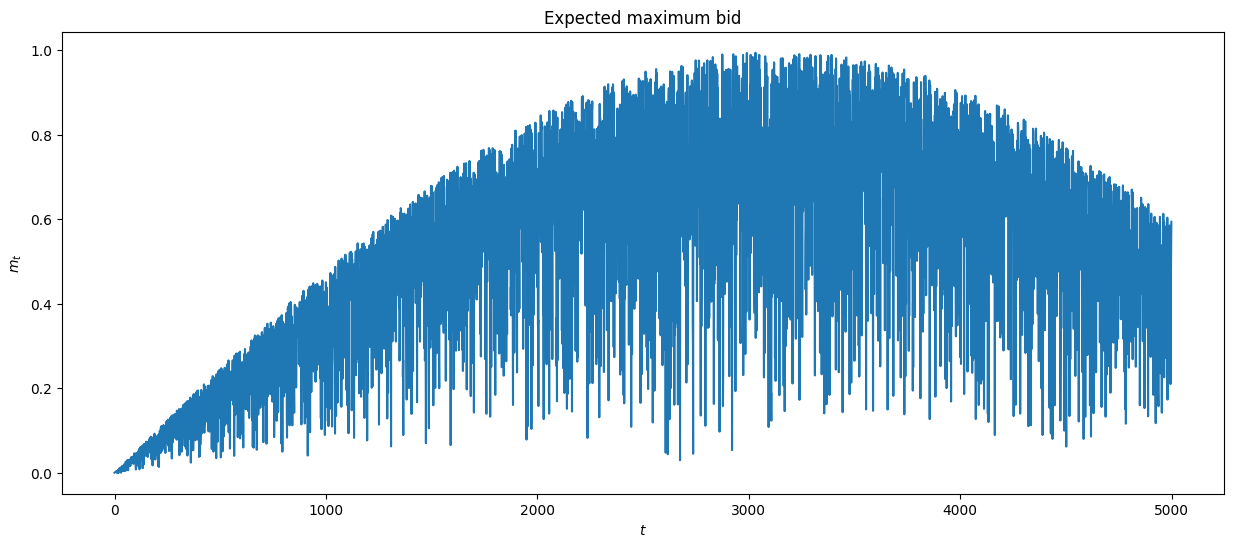

In [3]:
### Adversarial Bidders

n_advertisers = 3
n_users = 5000
Budget = 300
my_valuation = 0.6
rho = Budget/n_users

other_bids = []

pattern1 = lambda t: 1-np.abs(np.sin(0.00045*(t-3000)))
pattern2 = lambda t: 1-np.abs(np.sin(0.000045*t))-0.1
pattern3 = lambda t: 1-np.abs(np.sin(5*t/n_users))
pattern4 = lambda t: 1/(1+np.exp(-0.001*(t)))
pattern5 = lambda t: 1/(1+np.exp(-0.002*(t-2500)))

other_bids.append(generate_adversarial_bids(n_advertisers, n_users))
other_bids.append(np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t)*np.abs(np.sin(0.0005*t)) for t in range(n_users)]).T)
other_bids.append(np.array([np.random.uniform(0, pattern2(t), size = n_advertisers) for t in range(n_users)]).T)
other_bids.append(np.array([np.random.uniform(0, pattern3(t), size = n_advertisers) for t in range(n_users)]).T)
other_bids.append(np.array([np.random.uniform(0, pattern4(t), size = n_advertisers) for t in range(n_users)]).T)
#other_bids.append(np.array([np.random.uniform(0, pattern5(t), size = n_advertisers) for t in range(n_users)]).T)
other_bids.append(np.array([np.random.uniform(pattern3(t), 1, size = n_advertisers) for t in range(n_users)]).T)

n = 1
m_t = other_bids[n].max(axis=0)

plt.figure(figsize=(15, 6))
plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

In [4]:
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

In [6]:
-res.fun

0.06783518886679919

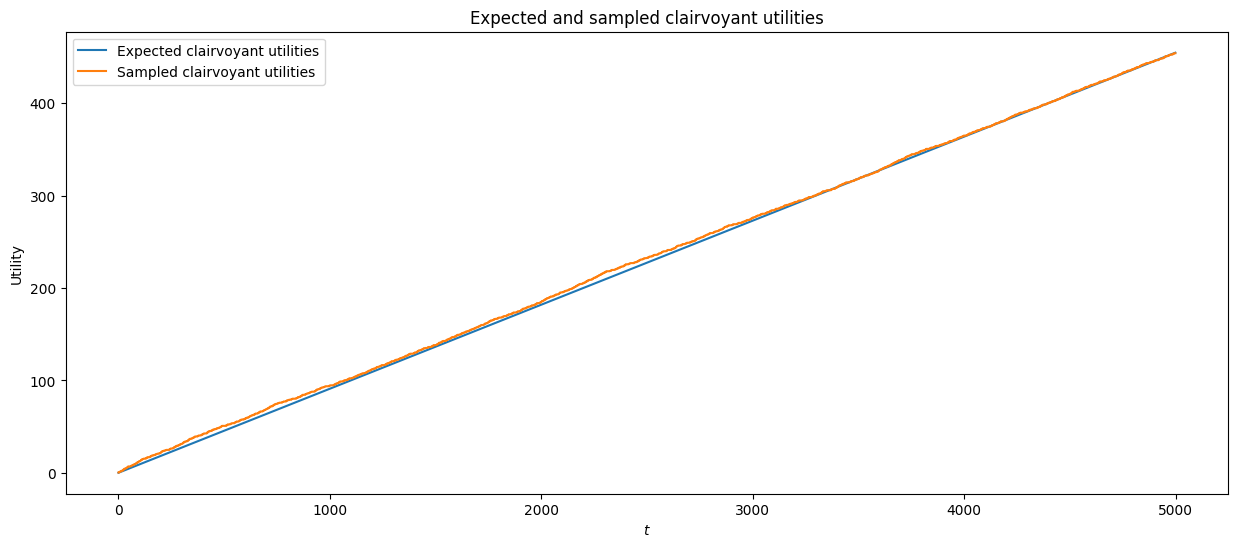

In [5]:
#find calirvoyant utilities by sampling its actions from the gamma distribution found by the linear program
clairvoyant_utilities = []
for u in range(n_users):
    clairvoyant_bids = np.random.choice(available_bids, p=gamma)
    clairvoyant_utilities.append((my_valuation-clairvoyant_bids)*int(clairvoyant_bids >= m_t[u]))

plt.figure(figsize=(15, 6))
plt.plot(np.cumsum(expected_clairvoyant_utilities), label='Expected clairvoyant utilities')
plt.plot(np.cumsum(clairvoyant_utilities), label='Sampled clairvoyant utilities')
plt.title('Expected and sampled clairvoyant utilities')
plt.xlabel('$t$')
plt.ylabel('Utility')
plt.legend()
plt.show()

sample from distribution and not use just one  action

In [6]:
gamma

array([0.       , 0.       , 0.7045204, 0.2954796, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       ])

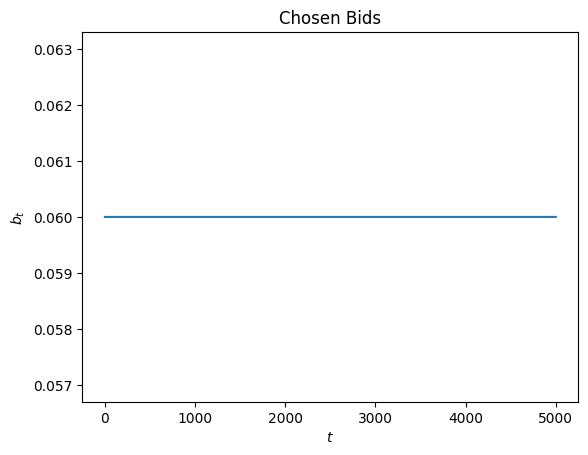

In [7]:
plt.plot(expected_clairvoyant_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

In [8]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=Budget,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[n][:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 1311


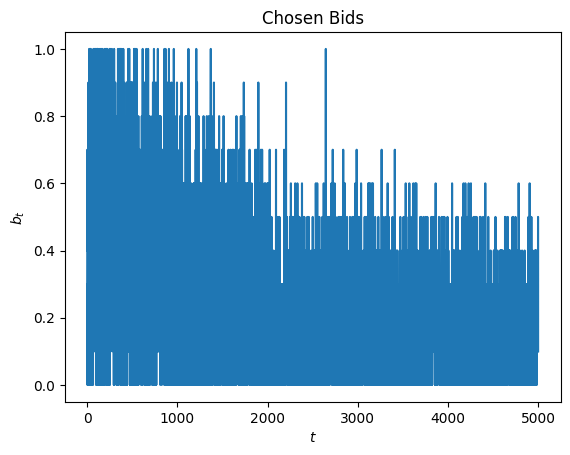

In [9]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

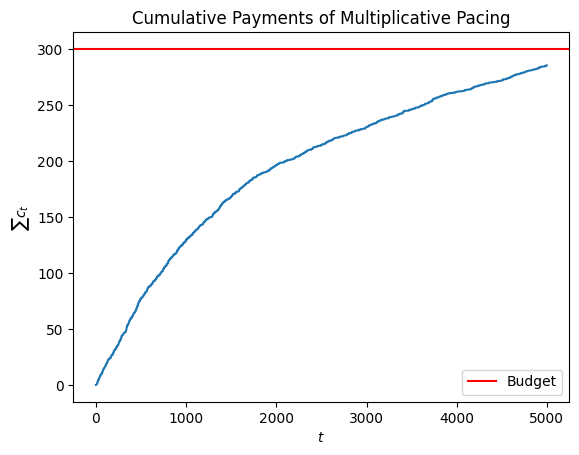

In [10]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(Budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

In [11]:
len(clairvoyant_utilities)

5000

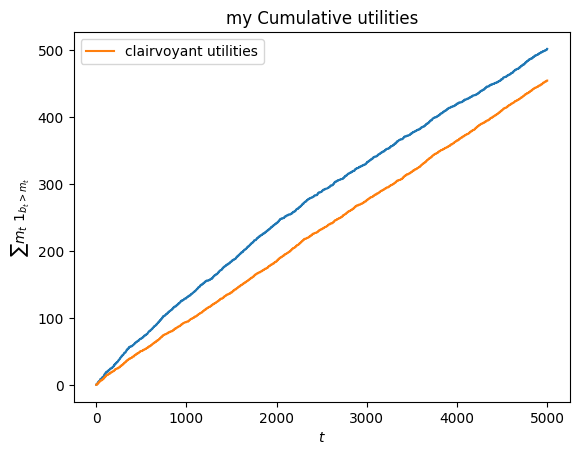

In [12]:
plt.title('my Cumulative utilities')
plt.plot(np.cumsum(utilities))
plt.plot(np.cumsum(clairvoyant_utilities), label='clairvoyant utilities')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

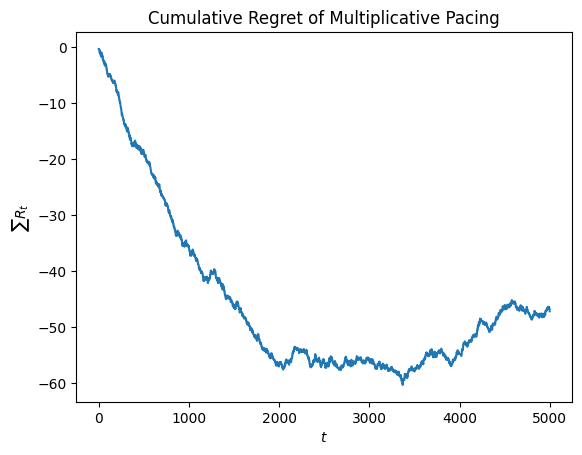

In [13]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

In [25]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):

    # select randomly an array of bids from 4 available functions
    other_bids = np.array([generate_bids(n_advertisers, np.random.normal(0.5, 5), t) for t in range(n_users)]).T

    #index = np.random.randint(0, len(other_bids))
    #Others = other_bids[index]
    m_t = other_bids.max(axis=0)

    # get the expected clairvoyant utilities
    available_bids = np.linspace(0,1,11)
    win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
    ## Linear Program
    c = -(my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
    clairvoyant_payments = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

    #find calirvoyant utilities by sampling its actions from the gamma distribution found by the linear program
    clairvoyant_utilities = []
    for u in range(n_users):
        clairvoyant_bids = np.random.choice(available_bids, p=gamma)
        clairvoyant_utilities.append((my_valuation-clairvoyant_bids)*int(clairvoyant_bids >= m_t[u]))


    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=Budget,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    
    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

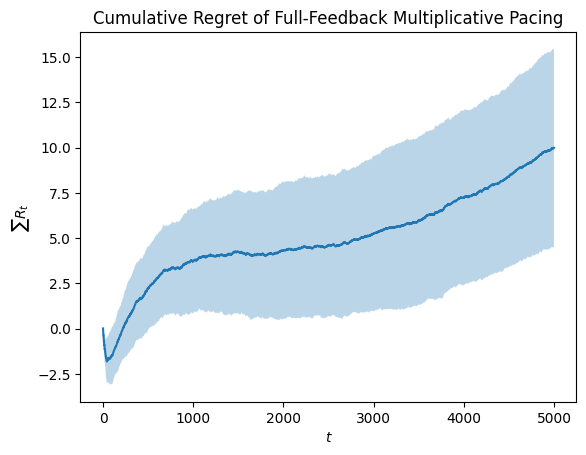

In [26]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()